# ssPA applications


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from process_met_data import ProcData
from process_pathways import ProcessPathways
import methods
import scipy.stats as stats
from scipy.spatial.distance import pdist
import statsmodels.api as sm
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, rand_score
from scipy.cluster.hierarchy import fcluster, fclusterdata, linkage, dendrogram
from sklearn.preprocessing import StandardScaler

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

In [2]:
def compute_ARI(df, md_col, n_clusters):
    true_labels = pd.factorize(md_col)[0]
    true_labels = [i+1 for i in true_labels]
    autoscale_dat = pd.DataFrame(StandardScaler().fit_transform(df.iloc[:, :-2]))
    clustering = fclusterdata(autoscale_dat, metric="Euclidean", method="ward", t=n_clusters, criterion="maxclust")
    ARI = adjusted_rand_score(true_labels, clustering)
    return ARI

def compute_RI(df, md_col, n_clusters):
    true_labels = pd.factorize(md_col)[0]
    true_labels = [i+1 for i in true_labels]
    autoscale_dat = pd.DataFrame(StandardScaler().fit_transform(df.iloc[:, :-2]))
    clustering = fclusterdata(autoscale_dat, metric="Euclidean", method="ward", t=n_clusters, criterion="maxclust")
    ARI = rand_score(true_labels, clustering)
    return ARI

In [11]:
def gsva_res(mat, pathways):
    base = importr('base')
#     print(dir(base))
    with localconverter(ro.default_converter + pandas2ri.converter):
        r_mat = ro.conversion.py2rpy(mat.T)
    r_mat = base.as_matrix(r_mat)  # abundance matrix
    row_vec = base.as_character(mat.columns.tolist())
    
    r_mat.rownames = row_vec
    r_list = ro.ListVector(pathways)  # pathways
    gsva_r = importr('GSVA')
    gsva_res = gsva_r.gsva(r_mat, r_list)
    with localconverter(ro.default_converter + pandas2ri.converter):
        gsva_df = ro.conversion.rpy2py(gsva_res)
    gsva_res_df = pd.DataFrame(gsva_df, index=pathways.keys(), columns=mat.iloc[:, :-1].index.tolist())
    return gsva_res_df

def ssgsea_results(mat, pathways):
    base = importr('base')
    with localconverter(ro.default_converter + pandas2ri.converter):
        r_mat = ro.conversion.py2rpy(mat.iloc[:, :-1].T)
    r_mat = base.as_matrix(r_mat)  # abundance matrix
    row_vec = base.as_character(mat.columns[:-1].tolist())
    r_mat.rownames = row_vec
    r_list = ro.ListVector(pathways)  # pathways
    gsva_r = importr('GSVA')
    gsva_res = gsva_r.gsva(r_mat, r_list, method="ssgsea")
    with localconverter(ro.default_converter + pandas2ri.converter):
        gsva_df = ro.conversion.rpy2py(gsva_res)
    ssgsea_scores = pd.DataFrame(gsva_df, index=pathways.keys(), columns=mat.iloc[:, :-1].index.tolist())
    return ssgsea_scores

def ssclustpa_proj_res(mat, pathways):
    pathway_matrices = []
    pathway_ids = []
    for pathway, compounds in pathways.items():
        single_pathway_matrix = mat.drop(mat.columns.difference(compounds), axis=1)
        if single_pathway_matrix.shape[1] >= 1:
            pathway_matrices.append(single_pathway_matrix.values)
            pathway_ids.append(pathway)

    scores = []
    for m in pathway_matrices:
        kmeans = KMeans(n_clusters=2).fit(m)
        centroids1 = kmeans.cluster_centers_[0]
        centroids2 = kmeans.cluster_centers_[1]

        vec = centroids1 - centroids2
        unit_vec = vec / np.linalg.norm(vec)
        proj_data = unit_vec.dot(m.T)
        scores.append(proj_data)

    scores_df = pd.DataFrame(scores, columns=mat.index, index=pathways.keys())
    return scores_df

def zscore_res(mat, pathways):
    mat_t = mat.T
    pathway_activities = []

    for k, v in pathways.items():
        pathway_mat = mat_t.iloc[mat_t.index.isin(v), :]
        pathway_mat = pathway_mat.to_numpy(dtype=float)
        zscores = stats.zscore(pathway_mat, axis=1)
        # avg_zscore = np.mean(zscores, axis=0)
        # pathway_act = avg_zscore / np.sqrt(pathway_mat.shape[0])
        sum_zscore = np.sum(zscores, axis=0)
        pathway_act = sum_zscore / np.sqrt(pathway_mat.shape[0])
        pathway_activities.append(pathway_act)
    pathway_activities_df = pd.DataFrame(pathway_activities, columns=mat.index, index=pathways.keys())
    return pathway_activities_df

def ssclustpa_res(mat, pathways):
    pathway_matrices = []
    pathway_ids = []
    for pathway, compounds in pathways.items():
        single_pathway_matrix = mat.drop(mat.columns.difference(compounds), axis=1)
        if single_pathway_matrix.shape[1] >= 1:
            pathway_matrices.append(single_pathway_matrix.values)
            pathway_ids.append(pathway)

    scores = []
    for m in pathway_matrices:
        kmeans = KMeans(n_clusters=2)
        new_data = kmeans.fit_transform(m)
        scores.append(new_data[:, 0])
    scores_df = pd.DataFrame(scores, columns=mat.index, index=pathways.keys())
    return scores_df

def kpca_res(mat, pathways):
    pathway_matrices = []
    pathway_ids = []
    for pathway, compounds in pathways.items():
        single_pathway_matrix = mat.drop(mat.columns.difference(compounds), axis=1)
        if single_pathway_matrix.shape[1] >= 1:
            pathway_matrices.append(single_pathway_matrix.values)
            pathway_ids.append(pathway)

    scores = []
    for n, m in enumerate(pathway_matrices):
        kpca = KernelPCA(n_components=2, kernel="rbf")
        new_data = kpca.fit_transform(m)
        scores.append(new_data[:, 0])
    scores_df = pd.DataFrame(scores, columns=mat.index, index=pathways.keys())
    return scores_df


def met_level(mat, pathways):
    all_pathway_mets = list(set([x for sublist in pathways_present.values() for x in sublist]))
    mat = mat[mat.columns.intersection(all_pathway_mets)]
    return mat.T

def all_met(mat, pathways):
    return mat.T

# Clustering on IBD dataset

In [4]:
ibd_data = ProcData("IBD")
ibd_data.process_IBD(id_type="CHEBI")
ibd_data_orig = ibd_data.data_proc

In [ ]:
ibd_data_orig.shape

In [5]:
# Load Reactome pathway dictionary
R76 = ProcessPathways("R76", "ChEBI2Reactome_All_Levels.txt", "Homo sapiens")
pathway_dict, pathway_names = R76.process_reactome()

# Remove large and uninformative pathways
# TODO Remove large and uninformative pathways
remove_paths = ["R-HSA-1430728", "R-HSA-1643685", "R-HSA-382551"]
pathway_dict = {k: v for k, v in pathway_dict.items() if k not in remove_paths}

# Remove pathways not present in the dataset
compounds_present = ibd_data_orig.columns.tolist()
pathways_present = {k: v for k, v in pathway_dict.items() if len([i for i in compounds_present if i in v]) > 1}
print(len(pathways_present))
print(len(compounds_present))

228
329


In [ ]:
# Filter metabolites 
ibd_data_orig = ibd_data.data_proc
all_pathway_mets = list(set([x for sublist in pathways_present.values() for x in sublist]))
md = ibd_data_orig[["IBD_status", "Group"]]

ibd_data_orig = ibd_data_orig[ibd_data_orig.columns.intersection(all_pathway_mets)]
ibd_data_orig = pd.concat([ibd_data_orig, md], axis=1)
print(ibd_data_orig.shape)

who_status_sample = dict(zip(ibd_data_orig.index, ibd_data_orig["IBD_status"]))
colours = sns.color_palette("tab10")

uniq_who = list(set(ibd_data_orig["IBD_status"]))
colors_dict = dict(zip(uniq_who, colours[0:4]))
group_dict = dict(zip(list(set(ibd_data_orig["Group"])), [colours[-3], colours[-2]]))
row_cols = dict(zip(ibd_data_orig.index, [colors_dict[i] for i in ibd_data_orig["IBD_status"]]))
row_cols2 = dict(zip(ibd_data_orig.index, [group_dict[i] for i in ibd_data_orig["Group"]]))

col_cols = ibd_data_orig.index.map(row_cols)
col_cols2 = ibd_data_orig.index.map(row_cols2)

g = sns.clustermap(ibd_data_orig.iloc[:, :-2],
#                z_score=1,
               row_colors=[col_cols, col_cols2],
               method="ward",
              yticklabels=False,
              xticklabels=False,
                  cmap="magma")

g.ax_heatmap.set_ylabel("Samples", fontsize=14)
g.ax_heatmap.set_xlabel("Metabolites", fontsize=14)

from matplotlib.pyplot import gcf

for label in list(set(ibd_data_orig["IBD_status"])):
    g.ax_col_dendrogram.bar(0, 0, color=colors_dict[label], label=label, linewidth=0)

l1 = g.ax_col_dendrogram.legend(title='IBD status', loc="center", ncol=1, bbox_to_anchor=(0.5, 1.05), bbox_transform=gcf().transFigure)

for label in list(set(ibd_data_orig["Group"])):
    g.ax_row_dendrogram.bar(0, 0, color=group_dict[label], label=label, linewidth=0)

l2 = g.ax_row_dendrogram.legend(title='Group', loc="center", ncol=1, bbox_to_anchor=(0.7, 1.05), bbox_transform=gcf().transFigure)

# plt.savefig("hpc_figures/IBD_cluster_metabolites_filt.png", dpi=300, transparent=True, bbox_inches='tight')

plt.show()

In [ ]:
compute_ARI(ibd_data_orig, ibd_data_orig["Group"], 2)

## IBD clustering performance plot (p-values)

In [6]:
def t_tests(matrix, classes, multiple_correction_method, testtype="ttest"):
    metabolites = matrix.columns.tolist()
    matrix['Target'] = pd.factorize(classes)[0]
    disease = matrix.loc[matrix["Target"] == 0]
    disease.drop(['Target'], axis=1, inplace=True)
    ctrl = matrix.loc[matrix["Target"] != 0]
    ctrl.drop(['Target'], axis=1, inplace=True)
    if testtype == "mwu":
        pvalues = stats.mannwhitneyu(disease, ctrl, axis=0)[1]
    else:
        pvalues = stats.ttest_ind(disease, ctrl)[1]
        
    print(len(pvalues))
    padj = sm.stats.multipletests(pvalues, 0.05, method=multiple_correction_method)
    results = pd.DataFrame(zip(metabolites, pvalues, padj[1]),
                           columns=["Metabolite", "P-value", "P-adjust"])
    return results

In [7]:
scores = kpca_res(ibd_data_orig.iloc[:, :-2], pathways_present).T

In [8]:
de_res_path = methods.t_tests(scores, ibd_data_orig["Group"], "fdr_bh", testtype="mwu")

/Users/cw2019/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/cw2019/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [9]:
sig_paths = de_res_path[de_res_path["P-adjust"] <= 0.05]
ranked_sig_paths = sig_paths.sort_values(by="P-adjust")["Metabolite"].tolist()

In [10]:
len(sig_paths)

116

In [11]:
aris_path = []
for i in range(0, len(ranked_sig_paths), 1):
    pathsranked = ranked_sig_paths[0:i+1]
    scores_filt = scores.loc[:, pathsranked]
    scores_df = pd.concat([scores_filt, ibd_data_orig[["Group", "IBD_status"]]], axis=1)
#     aris_path.append(compute_ARI(scores_df, scores_df["Group"], 2))
    aris_path.append(compute_ARI(scores_df, scores_df["Group"], 2))    

In [12]:
all_mets = ibd_data_orig.iloc[:, :-2]
all_pathway_mets = list(set([x for sublist in pathways_present.values() for x in sublist]))
md = ibd_data_orig[["IBD_status", "Group"]]

ibd_data_orig = ibd_data_orig[ibd_data_orig.columns.intersection(all_pathway_mets)]
ibd_data_orig = pd.concat([ibd_data_orig, md], axis=1)
de_res_met = methods.t_tests(ibd_data_orig.iloc[:, :-2], ibd_data_orig["Group"], "fdr_bh")
sig_mets = de_res_met[de_res_met["P-adjust"] <= 0.05]
ranked_sig_mets = sig_mets.sort_values(by="P-adjust")["Metabolite"].tolist()
print(len(sig_mets))

aris_met = []
for i in range(0, len(ranked_sig_mets), 1):
    metsranked = ranked_sig_mets[0:i+1]
    mets_filt = all_mets.loc[:, metsranked]
    mets_df = pd.concat([mets_filt, ibd_data_orig[["Group", "IBD_status"]]], axis=1)
#     aris_met.append(compute_ARI(mets_df, mets_df["Group"], 2))
    aris_met.append(compute_ARI(mets_df, mets_df["Group"], 2))

/Users/cw2019/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/cw2019/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


69


In [ ]:
len(aris_path) - len(aris_met)

In [13]:
aris_met = aris_met + [np.nan for i in range(len(aris_path) - len(aris_met))]

In [14]:
# use boxplots every 10 entities
ari_df = pd.DataFrame(np.array([aris_met, aris_path]).T, columns=["Metabolite", "Pathway"])
import math
ari_df["interval"] = [i for i in range(1, math.ceil(len(aris_path)/10)+1) for x in range(10)][0:len(aris_path)]

In [15]:
ari_df_l = pd.melt(ari_df, value_vars=["Metabolite", "Pathway"], id_vars="interval", value_name="ARI", var_name="Entity type")

In [16]:
ari_df

,Metabolite,Pathway,interval
0,0.182052,0.109977,1
1,0.294105,0.222237,1
2,0.271969,0.108625,1
3,0.259228,0.097755,1
4,0.272498,0.176074,1
...,...,...,...
111,NaN,0.010623,12
112,NaN,0.178110,12
113,NaN,0.177393,12
114,NaN,0.102988,12


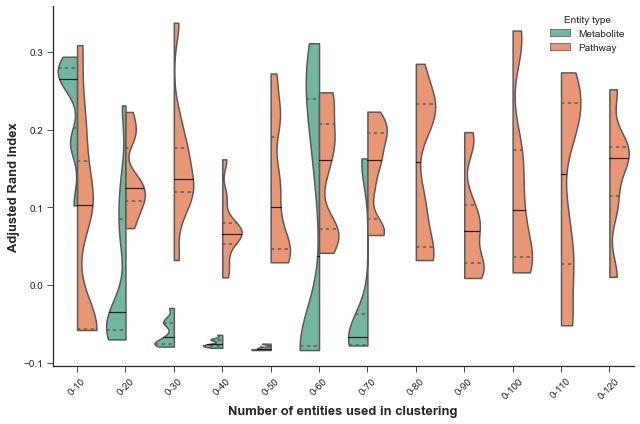

In [48]:
fig, ax = plt.subplots(figsize=(9, 6))
ax = sns.violinplot(x="interval", y="ARI", hue="Entity type",
                    data=ari_df_l, palette="Set2", split=True, ax=ax, scale="width", inner="quartile", bw=0.3, cut=0)
ax.set_xticklabels([str(0)+"-"+str(a+10) for a in range(0, 120, 10)], rotation=45)

for l in ax.lines[1::3]:
    l.set_linestyle('-')
    l.set_linewidth(1.2)
    l.set_color('black')
    l.set_alpha(0.8)

plt.xlabel("Number of entities used in clustering", fontsize=13, fontweight="bold")
plt.ylabel("Adjusted Rand Index", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.style.use("seaborn-ticks")
sns.despine()
# plt.savefig("/Users/cw2019/Documents/PhD/Pathway_modelling/pathway-models/figures/IBD_RI_analysis_violinplots_p_less_005.png", dpi=350, transparent=True, bbox_inches='tight')
plt.show()

# Biological interpretaion of IBD dataset - clustering based on pathway scores (kPCA method)

In [28]:
scores = kpca_res(ibd_data_orig.iloc[:, :-2], pathways_present).T
de_res_path = methods.t_tests(scores, ibd_data_orig["Group"], "fdr_bh")

/Users/cw2019/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/cw2019/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [8]:
ibd_data_orig.index

Index(['CSM5FZ3N', 'CSM5FZ4C', 'CSM5MCVV', 'CSM67UA2', 'CSM79HGP', 'CSM79HMZ',
       'CSM5FZ3T', 'CSM5FZ44', 'CSM5MCVN', 'CSM67UBH',
       ...
       'PSMB4MBK', 'PSMA266I', 'PSMA266Q', 'PSMA269I', 'PSMB4MBQ', 'PSMA265X',
       'PSMA2675', 'PSMA269W', 'PSMA26A3', 'PSMB4MC5'],
      dtype='object', length=546)

In [29]:
top50paths = de_res_path.sort_values(by="P-adjust")["Metabolite"].tolist()[0:50]
scores = scores.loc[:, top50paths]
scores_df = pd.concat([scores, ibd_data_orig[["Group", "IBD_status"]]], axis=1)

who_status_sample = dict(zip(ibd_data_orig.index, ibd_data_orig["IBD_status"]))
colours = sns.color_palette("tab10")

ibd_status = ["nonIBD", "CD", "UC"]
colors_dict = dict(zip(ibd_status, ["lightseagreen","gold", "tab:purple"]))
group_dict = {"non-IBD":"lightseagreen", "IBD":"lightcoral"}
row_cols = dict(zip(ibd_data_orig.index, [colors_dict[i] for i in ibd_data_orig["IBD_status"]]))
row_cols2 = dict(zip(ibd_data_orig.index, [group_dict[i] for i in ibd_data_orig["Group"]]))
print(colors_dict)
print(group_dict)

{'nonIBD': 'lightseagreen', 'CD': 'gold', 'UC': 'tab:purple'}
{'non-IBD': 'lightseagreen', 'IBD': 'lightcoral'}


/Users/cw2019/opt/anaconda3/envs/py39/lib/python3.9/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


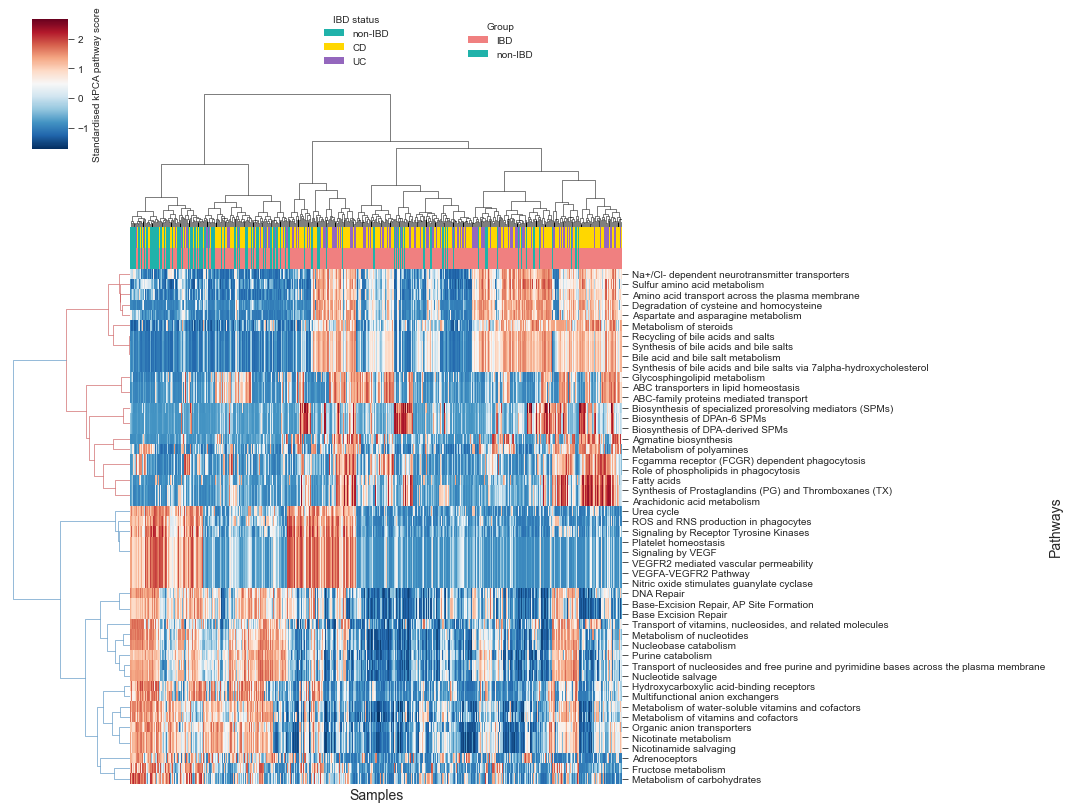

In [30]:

col_cols = ibd_data_orig.index.map(row_cols)
col_cols2 = ibd_data_orig.index.map(row_cols2)
sns.set_style("ticks")
g = sns.clustermap(scores_df.iloc[:, :-2].T,
               z_score=0,
               col_colors=[col_cols, col_cols2],
               method="ward",
              yticklabels=True,
              xticklabels=False,
                  cmap="RdBu_r",
                  cbar_kws={'label': 'Standardised kPCA pathway score'},
                  cbar_pos=(0.05, 0.9, 0.05, 0.18),
                  tree_kws={'colors':'black'})
dendro_cols = sns.color_palette("RdBu_r")
g.ax_heatmap.set_xlabel("Samples", fontsize=14)
g.ax_heatmap.set_ylabel("Pathways", fontsize=14)

top50_dict = dict(zip(range(0, 50), top50paths))
top50_map = [top50_dict[i] for i in g.dendrogram_row.reordered_ind]
g.ax_heatmap.set_yticklabels([pathway_names[i] for i in top50_map])

# legends 
from matplotlib.pyplot import gcf
for label in ibd_status:
    if label == "nonIBD":
        g.ax_col_dendrogram.bar(0, 0, color=colors_dict[label], label="non-IBD", linewidth=0)
        
    else:
        g.ax_col_dendrogram.bar(0, 0, color=colors_dict[label], label=label, linewidth=0)

l1 = g.ax_col_dendrogram.legend(title='IBD status', loc="center", ncol=1, bbox_to_anchor=(0.5, 1.05), bbox_transform=gcf().transFigure)

for label in list(set(ibd_data_orig["Group"])):
    g.ax_row_dendrogram.bar(0, 0, color=group_dict[label], label=label, linewidth=0)

l2 = g.ax_row_dendrogram.legend(title='Group', loc="center", ncol=1, bbox_to_anchor=(0.7, 1.05), bbox_transform=gcf().transFigure)

# set dendrogram colours
for l in g.ax_row_dendrogram.collections:
    l.set_edgecolor([dendro_cols[5] for i in range(0, 25)] + [dendro_cols[0] for i in range(0, 25)] )
    

plt.show()

In [ ]:
upreg_ibd = g.dendrogram_row.reordered_ind[0:15]
downreg_ibd = g.dendrogram_row.reordered_ind[15:]

In [ ]:
top50_dict = dict(zip(range(0, 50), top50paths))
top50_map = [top50_dict[i] for i in g.dendrogram_row.reordered_ind]
lastcluster1_ind = top50_map.index("R-HSA-2142753")
upreg_ibd_paths = top50_map[0:lastcluster1_ind+1]
downreg_ibd_paths = top50_map[lastcluster1_ind+1:]

In [ ]:
print(upreg_ibd_paths)

In [32]:
# use gsea to determine cluster direction
print(scores_df[scores_df["Group"] == "IBD"]["R-HSA-442660"].mean())
print(scores_df[scores_df["Group"] != "IBD"]["R-HSA-442660"].mean())

0.05330268250579031
-0.16227705562873926


## PCAs

In [ ]:
scores = kpca_res(ibd_data_orig.iloc[:, :-2], pathways_present).T
de_res_path = methods.t_tests(scores, ibd_data_orig["Group"], "fdr_bh")
top50paths = de_res_path.sort_values(by="P-adjust")["Metabolite"].tolist()
scores = scores.loc[:, top50paths]
scores_df = pd.concat([scores, ibd_data_orig[["Group", "IBD_status"]]], axis=1)

In [ ]:
# standardise scores df
scores_df.iloc[:, :-2] = StandardScaler().fit_transform(scores_df.iloc[:, :-2].to_numpy())

In [ ]:
pca_ss = PCA(n_components=2).fit_transform(scores_df.iloc[:, :-2])
pca_df_ss = pd.DataFrame(pca_ss)
pca_df_ss["Group"] = ibd_data_orig["IBD_status"].tolist()
plt.figure(figsize=(8, 8))
sns.pairplot(data=pca_df_ss, hue="Group")
plt.show()

In [ ]:
pca_df

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,  figsize=(10, 10))
sns.set_style("ticks")
sns.set_palette("icefire_r")
sns.scatterplot(x=pca_df_filt.iloc[:, 0], y=pca_df_filt.iloc[:, 1], hue=pca_df_filt["Group"],  ax=ax1, s=150, alpha=0.8)
sns.scatterplot(x=pca_df_ss.iloc[:, 0], y=pca_df_ss.iloc[:, 1], hue=pca_df_ss["Group"],  ax=ax2, s=150, alpha=0.8)
sns.kdeplot(x=pca_df_filt.iloc[:, 0], hue=pca_df_filt["Group"], ax=ax3, fill=True, alpha=0.3)
sns.kdeplot(x=pca_df_ss.iloc[:, 0], hue=pca_df_ss["Group"], ax=ax4, fill=True, alpha=0.3)

ax1.set_ylabel("PC2")
ax1.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_xlabel("PC1")
ax3.set_xlabel("PC1 scores")
ax4.set_xlabel("PC1 scores")


sns.despine()
plt.tight_layout()
plt.savefig("hpc_figures/IBD_PCA_met_vs_kPCA_top50.png", dpi=300)
plt.show()

In [ ]:
pca_df

In [ ]:
# 2 sided KS test
stats.ks_2samp(pca_df[pca_df["Group"].isin(["CD", "UC"])][0], pca_df[pca_df["Group"].isin(["nonIBD"])][0])

In [ ]:
de_res_met = methods.t_tests(ibd_data_orig.iloc[:, :-2], ibd_data_orig["Group"], "fdr_bh")
top50mets = de_res_met.sort_values(by="P-adjust")["Metabolite"].tolist()
pca_filt = PCA(n_components=5).fit_transform(ibd_data_orig.loc[:, top50mets])
pca_df_filt = pd.DataFrame(pca_filt)
pca_df_filt["Group"] = ibd_data_orig["IBD_status"].tolist()

In [ ]:
stats.ks_2samp(pca_df_filt[pca_df_filt["Group"].isin(["CD", "UC"])][0], pca_df_filt[pca_df_filt["Group"].isin(["nonIBD"])][0])

In [ ]:
stats.ks_2samp(pca_df_ss[pca_df_ss["Group"].isin(["CD", "UC"])][0], pca_df_ss[pca_df_ss["Group"].isin(["nonIBD"])][0])

In [ ]:
# Biological interpretaion of IBD dataset - clustering based on pathway scores (kPCA method)
scores = kpca_res(ibd_data_orig.iloc[:, :-2], pathways_present).T
de_res_path = methods.t_tests(scores, ibd_data_orig["Group"], "fdr_bh")
ibd_data_orig.index
top50paths = de_res_path.sort_values(by="P-adjust")["Metabolite"].tolist()[0:50]
scores = scores.loc[:, top50paths]
scores_df = pd.concat([scores, ibd_data_orig[["Group", "IBD_status"]]], axis=1)

who_status_sample = dict(zip(ibd_data_orig.index, ibd_data_orig["IBD_status"]))
colours = sns.color_palette("tab10")

ibd_status = ["nonIBD", "CD", "UC"]
colors_dict = dict(zip(ibd_status, ["lightseagreen","gold", "tab:purple"]))
group_dict = {"non-IBD":"lightseagreen", "IBD":"lightcoral"}
row_cols = dict(zip(ibd_data_orig.index, [colors_dict[i] for i in ibd_data_orig["IBD_status"]]))
row_cols2 = dict(zip(ibd_data_orig.index, [group_dict[i] for i in ibd_data_orig["Group"]]))
print(colors_dict)
print(group_dict)

col_cols = ibd_data_orig.index.map(row_cols)
col_cols2 = ibd_data_orig.index.map(row_cols2)
sns.set_style("ticks")
g = sns.clustermap(scores_df.iloc[:, :-2].T,
               z_score=0,
               col_colors=[col_cols, col_cols2],
               method="ward",
              yticklabels=True,
              xticklabels=False,
                  cmap="RdBu_r",
                  cbar_kws={'label': 'Standardised kPCA pathway score'},
                  cbar_pos=(0.05, 0.9, 0.05, 0.18),
                  tree_kws={'colors':'black'})
dendro_cols = sns.color_palette("RdBu_r")
g.ax_heatmap.set_xlabel("Samples", fontsize=14)
g.ax_heatmap.set_ylabel("Pathways", fontsize=14)
g.ax_heatmap.set_yticklabels([pathway_names[i] for i in top50_map])

# legends 
from matplotlib.pyplot import gcf
for label in ibd_status:
    if label == "nonIBD":
        g.ax_col_dendrogram.bar(0, 0, color=colors_dict[label], label="non-IBD", linewidth=0)
        
    else:
        g.ax_col_dendrogram.bar(0, 0, color=colors_dict[label], label=label, linewidth=0)

l1 = g.ax_col_dendrogram.legend(title='IBD status', loc="center", ncol=1, bbox_to_anchor=(0.5, 1.05), bbox_transform=gcf().transFigure)

for label in list(set(ibd_data_orig["Group"])):
    g.ax_row_dendrogram.bar(0, 0, color=group_dict[label], label=label, linewidth=0)

l2 = g.ax_row_dendrogram.legend(title='Group', loc="center", ncol=1, bbox_to_anchor=(0.7, 1.05), bbox_transform=gcf().transFigure)

# set dendrogram colours
for l in g.ax_row_dendrogram.collections:
    l.set_edgecolor([dendro_cols[5] for i in range(0, 25)] + [dendro_cols[0] for i in range(0, 25)] )
    
# set y label colours
ytickcols = [dendro_cols[5] for i in range(lastcluster1_ind+1)]+ [dendro_cols[0] for i in range(lastcluster1_ind+1, 50)]
[t.set_color(ytickcols[n]) for n, t in enumerate(g.ax_heatmap.get_yticklabels())]

plt.style.use("seaborn-ticks")

plt.savefig("hpc_figures/IBD_cluster_kPCA_top50.png", dpi=350, transparent=True, bbox_inches='tight')

plt.show()

color=[dendro_cols[5] for i in range(lastcluster1_ind+1)]+ [dendro_cols[0] for i in range(lastcluster1_ind+1, 50)]
sns.color_palette("RdBu_r")
compute_ARI(scores_df.iloc[:, :-2], scores_df["Group"], 2)
upreg_ibd = g.dendrogram_row.reordered_ind[0:15]
downreg_ibd = g.dendrogram_row.reordered_ind[15:]
top50_dict = dict(zip(range(0, 50), top50paths))
top50_map = [top50_dict[i] for i in g.dendrogram_row.reordered_ind]
lastcluster1_ind = top50_map.index("R-HSA-2142753")
upreg_ibd_paths = top50_map[0:lastcluster1_ind+1]
downreg_ibd_paths = top50_map[lastcluster1_ind+1:]
print(upreg_ibd_paths)
# use gsea to determine cluster direction
print(scores_df[scores_df["Group"] == "IBD"]["R-HSA-442660"].mean())
print(scores_df[scores_df["Group"] != "IBD"]["R-HSA-442660"].mean())
## PCAs
scores = kpca_res(ibd_data_orig.iloc[:, :-2], pathways_present).T
de_res_path = methods.t_tests(scores, ibd_data_orig["Group"], "fdr_bh")
top50paths = de_res_path.sort_values(by="P-adjust")["Metabolite"].tolist()
scores = scores.loc[:, top50paths]
scores_df = pd.concat([scores, ibd_data_orig[["Group", "IBD_status"]]], axis=1)
# standardise scores df
scores_df.iloc[:, :-2] = StandardScaler().fit_transform(scores_df.iloc[:, :-2].to_numpy())
pca_ss = PCA(n_components=2).fit_transform(scores_df.iloc[:, :-2])
pca_df_ss = pd.DataFrame(pca_ss)
pca_df_ss["Group"] = ibd_data_orig["IBD_status"].tolist()
plt.figure(figsize=(8, 8))
sns.pairplot(data=pca_df_ss, hue="Group")
plt.show()
pca_df
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,  figsize=(10, 10))
sns.set_style("ticks")
sns.set_palette("icefire_r")
sns.scatterplot(x=pca_df_filt.iloc[:, 0], y=pca_df_filt.iloc[:, 1], hue=pca_df_filt["Group"],  ax=ax1, s=150, alpha=0.8)
sns.scatterplot(x=pca_df_ss.iloc[:, 0], y=pca_df_ss.iloc[:, 1], hue=pca_df_ss["Group"],  ax=ax2, s=150, alpha=0.8)
sns.kdeplot(x=pca_df_filt.iloc[:, 0], hue=pca_df_filt["Group"], ax=ax3, fill=True, alpha=0.3)
sns.kdeplot(x=pca_df_ss.iloc[:, 0], hue=pca_df_ss["Group"], ax=ax4, fill=True, alpha=0.3)

ax1.set_ylabel("PC2")
ax1.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_xlabel("PC1")
ax3.set_xlabel("PC1 scores")
ax4.set_xlabel("PC1 scores")


sns.despine()
plt.tight_layout()
plt.savefig("hpc_figures/IBD_PCA_met_vs_kPCA_top50.png", dpi=300)
plt.show()
pca_df
# 2 sided KS test
stats.ks_2samp(pca_df[pca_df["Group"].isin(["CD", "UC"])][0], pca_df[pca_df["Group"].isin(["nonIBD"])][0])
de_res_met = methods.t_tests(ibd_data_orig.iloc[:, :-2], ibd_data_orig["Group"], "fdr_bh")
top50mets = de_res_met.sort_values(by="P-adjust")["Metabolite"].tolist()
pca_filt = PCA(n_components=5).fit_transform(ibd_data_orig.loc[:, top50mets])
pca_df_filt = pd.DataFrame(pca_filt)
pca_df_filt["Group"] = ibd_data_orig["IBD_status"].tolist()
stats.ks_2samp(pca_df_filt[pca_df_filt["Group"].isin(["CD", "UC"])][0], pca_df_filt[pca_df_filt["Group"].isin(["nonIBD"])][0])
stats.ks_2samp(pca_df_ss[pca_df_ss["Group"].isin(["CD", "UC"])][0], pca_df_ss[pca_df_ss["Group"].isin(["nonIBD"])][0])

# Test classification - random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,  RocCurveDisplay, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score


In [ ]:
labels = pd.factorize(ibd_data_orig["Group"])[0]

In [ ]:
scores = gsva_res(ibd_data_orig.iloc[:, :-2], pathways_present).T
# de_res_path = methods.t_tests(scores, ibd_data_orig["Group"], "fdr_bh")
# top50paths = de_res_path.sort_values(by="P-adjust")["Metabolite"].tolist()[0:50]
# scores = scores.loc[:, top50paths]
scores_df = pd.concat([scores, ibd_data_orig[["Group", "IBD_status"]]], axis=1)

In [ ]:
# met level
skf = StratifiedKFold(n_splits=3)
X = ibd_data_orig.iloc[:, :-2].to_numpy()
y = labels
clf = RandomForestClassifier()
print(cross_val_score(clf, X, y, cv=skf, scoring="roc_auc"))

In [ ]:
# pathway level
scores = gsva_res(ibd_data_orig.iloc[:, :-2], pathways_present).T
de_res_path = methods.t_tests(scores, ibd_data_orig["Group"], "fdr_bh")
top50paths = de_res_path.sort_values(by="P-adjust")["Metabolite"].tolist()[0:50]
scores = scores.loc[:, top50paths]
scores_df = pd.concat([scores, ibd_data_orig[["Group", "IBD_status"]]], axis=1)

skf_p = StratifiedKFold(n_splits=3)
X_p = scores_df.iloc[:, :-2].to_numpy()
y_p = labels
clf_p = RandomForestClassifier()
print(cross_val_score(clf_p, X_p, y_p, cv=skf_p, scoring="roc_auc"))

In [ ]:
skf_p = StratifiedKFold(n_splits=3)
X_p = scores_df.iloc[:, :-2].to_numpy()
y_p = labels
base_fpr_p = np.linspace(0, 1, 101)
roc_all_p = []
tprs_p = []
aurocs_p = []

for i in range(0, 50):
    for train, test in skf_p.split(X_p, y_p):
        clf_p = RandomForestClassifier()
        clf_p.fit(X_p[train], y_p[train])
#         roc_all_p.append(roc_curve(y_p[test], clf_p.predict_proba(X_p[test])[:,1]))
        fpr, tpr, _ = roc_curve(y_p[test], clf_p.predict_proba(X_p[test])[:,1])
        tpr = np.interp(base_fpr_p, fpr, tpr)
        tpr[0] = 0.0
        tprs_p.append(tpr)
        aurocs_p.append(roc_auc_score(y_p[test], clf_p.predict_proba(X_p[test])[:, 1]))

tprs_p = np.array(tprs_p)
mean_tprs_p = tprs_p.mean(axis=0)
std_p = tprs_p.std(axis=0)
tprs_upper_p = np.minimum(mean_tprs_p + std_p, 1)
tprs_lower_p = mean_tprs_p - std_p


In [ ]:
print(np.mean(aurocs_p))

In [ ]:
print(np.std(aurocs_p))

In [ ]:
skf = StratifiedKFold(n_splits=3)
X = ibd_data_orig.iloc[:, :-2].to_numpy()
y = labels
base_fpr = np.linspace(0, 1, 101)
roc_all = []
tprs = []
aurocs = []

for i in range(0, 50):
    for train, test in skf.split(X, y):
        clf = RandomForestClassifier()
        clf.fit(X[train], y[train])
#         roc_all.append(roc_curve(y[test], clf.predict_proba(X[test])[:,1]))
        fpr, tpr, _ = roc_curve(y[test], clf.predict_proba(X[test])[:,1])
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
        aurocs.append(roc_auc_score(y[test], clf.predict_proba(X[test])[:, 1]))
        
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)
tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std


In [ ]:
print(np.mean(aurocs))

In [ ]:
print(np.std(aurocs))

In [ ]:
plt.figure(figsize=(7,7))
plt.style.use("seaborn-ticks")
plt.plot(base_fpr, mean_tprs, 'b', label="Metabolites")
plt.plot(base_fpr_p, mean_tprs_p, 'g', label="ssClustPAproj scores")
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2)
plt.fill_between(base_fpr_p, tprs_lower_p, tprs_upper_p, color='grey', alpha=0.2)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.tight_layout()
plt.savefig("hpc_figures/roc_curve_IBD_ssClustPAproj.png", dpi=300)
plt.show()

## Feature importance (permutation)

In [ ]:
# pathway level
scores = kpca_res(ibd_data_orig.iloc[:, :-2], pathways_present).T
# de_res_path = methods.t_tests(scores, ibd_data_orig["Group"], "fdr_bh")
# top50paths = de_res_path.sort_values(by="P-adjust")["Metabolite"].tolist()[0:50]
# scores = scores.loc[:, top50paths]
scores_df = pd.concat([scores, ibd_data_orig[["Group", "IBD_status"]]], axis=1)

skf_p = StratifiedKFold(n_splits=3)
X_p = scores_df.iloc[:, :-2].to_numpy()
y_p = labels

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_p, y_p, test_size=30)

In [ ]:
forest = RandomForestClassifier()
forest.fit(X_p, y_p)

In [ ]:
from sklearn.inspection import permutation_importance
import time
start_time = time.time()
result = permutation_importance(
    forest, X_p, y_p, n_repeats=30, scoring="roc_auc"
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=scores_df.iloc[:, :-2].columns)

In [ ]:
forest_importances.abs().sort_values()

In [ ]:
df = forest_importances.to_frame()

In [ ]:
df["Name"] = df.index.map(pathway_names)

In [ ]:
df = df.sort_values(by=0, key=abs, ascending=False)
df.to_csv("IBD_KPCA_RF_feature_importances.csv")